In [1]:
import numpy as np
import math
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 

def takagi_chen(H):
    # takagi factoriziation part
    sing_vs, Q = linalg.eigh(H) 
    
#     print('Q')
#     print(Q[0,:4].real)
#     print(Q[1,:4].real)
#     print(Q[2,:4].real)
#     print(Q[3,:4].real)
    
    phase_mat = np.diag(
                [np.exp(-1.j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)  
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]  
    Qp = (Qp[:, sort_array])

    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def psd(npade):
    
    b = np.zeros(2 * npade)
    mat_xi = np.zeros((2 * npade, 2 * npade))
    mat_varsigma = np.zeros((2 * npade - 1, 2 * npade - 1))
    tilde_eta_ = np.zeros(npade, dtype = complex)         # namely cpcoef in evaluatepara.f90
    pole_ = np.zeros(npade, dtype = complex)              # namely cppole in evaluatepara.f90

    for i in range(2 * npade):
        b[i] = 2 * (i) + 1

    for i in range(2 * npade):
        for j in range(2 * npade):
            if (i == j-1 or i == j+1) :
                mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

    eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
    eigval_xi = np.sort(eigval_xi)
            
    for i in range(2 * npade - 1):
        for j in range(2 * npade -1):
            if (i == j-1 or i == j+1) :
                mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

    eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
    eigval_varsigma = np.sort(eigval_varsigma)

    for i in range(npade):
        pole_[i] = (0. + 2.j) / abs(eigval_xi[i])
        eigval_xi[i] = 4.0 / eigval_xi[i]**2
    for i in range(npade-1):
        eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

    for i in range(npade):
        tilde_eta_[i] = 0.5 * npade * (2 * npade + 1)
        for j in range(i):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        for j in range(i+1,npade):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        tilde_eta_[i] = (-1. + 0.j) * tilde_eta_[i]
    
    return pole_, tilde_eta_

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j * sigma * omega / hbar * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j *  sigma * omega / hbar * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j *  sigma * omega / hbar * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j *  sigma * omega / hbar * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if (omega / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma *  band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma *  band_center)**2 + band_width**2)\
              / 10e+22
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def J_fit(omega, rate, eta):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] * (1**2) / (rate[i] * 1 + 1.j * omega )
    return fun

def J_fit_fano(omega, rate, eta, ifff):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] * (1**2) * math.factorial(int(ifff[i])) / (rate[i] * 1 + 1.j * omega )**(int(ifff[i]) + 1)
    return fun

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 50.0
omega_min = -50.0
omega_sample = 10000 + 1
sigma = 1
omega_plt = np.linspace(omega_min, omega_max, omega_sample)
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)
bath_corr_exact_freq = np.zeros(omega_sample, dtype = complex)

print('Done!')

Done!


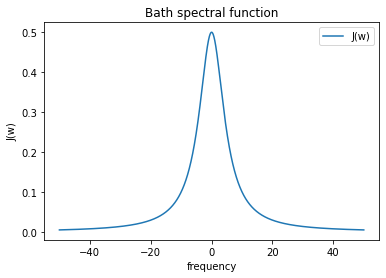

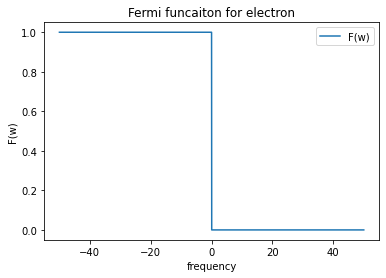

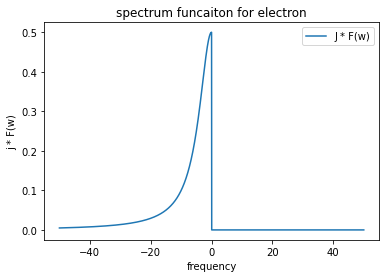

spectral_pole 
 (5+0j)
spectral_eta 
 (2.885217226537307+2.4686721946425325j)


In [3]:
# the information of fermi funcaiton
T = 0.001              #eV
chemical_potential = 0.0 #ev

omega = omega - chemical_potential

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if (sigma * omega[i] / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( sigma * omega[i] / (T) ) )
    elif (sigma * omega[i] / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w + band_center)**2 + band_width**2)
sys_bath_coupling = 1.0  #eV, is equal to HEOM-QUICK
band_width = 5.0        #eV
band_center = 0.0       #eV

bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega_plt - sigma * band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * sigma * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((sigma * band_center + 1.j * band_width) / T )) / hbar**2

plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega_plt, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega_plt, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

plt.title("spectrum funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("j * F(w)") 
plt.plot(omega_plt, bath_spectral.real * fermi.real, label = 'J * F(w)')
plt.legend(loc=1)
plt.show()


bath_corr_exact_freq = bath_spectral * fermi

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


In [4]:
# compare the pade results and the exact correlation function in time domain
# exact results

j = 0
for i in range(time_sample_for_corr):
    j = j + 1
    bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
    bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
    bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])
    if j % 50 == 0 :
        print("run times / total times:", j ,"/", time_sample_for_corr-1, " = ", '%.2f'%(j/(time_sample_for_corr-1)))

print('Done!')

<ipython-input-4-eb8baefba233>:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)


run times / total times: 50 / 1000  =  0.05
run times / total times: 100 / 1000  =  0.10
run times / total times: 150 / 1000  =  0.15
run times / total times: 200 / 1000  =  0.20
run times / total times: 250 / 1000  =  0.25
run times / total times: 300 / 1000  =  0.30
run times / total times: 350 / 1000  =  0.35
run times / total times: 400 / 1000  =  0.40
run times / total times: 450 / 1000  =  0.45
run times / total times: 500 / 1000  =  0.50
run times / total times: 550 / 1000  =  0.55
run times / total times: 600 / 1000  =  0.60
run times / total times: 650 / 1000  =  0.65
run times / total times: 700 / 1000  =  0.70
run times / total times: 750 / 1000  =  0.75
run times / total times: 800 / 1000  =  0.80
run times / total times: 850 / 1000  =  0.85
run times / total times: 900 / 1000  =  0.90
run times / total times: 950 / 1000  =  0.95
run times / total times: 1000 / 1000  =  1.00
Done!


run times / total times: 0 / 10000  =  0.00
run times / total times: 1000 / 10000  =  0.10
run times / total times: 2000 / 10000  =  0.20
run times / total times: 3000 / 10000  =  0.30
run times / total times: 4000 / 10000  =  0.40
run times / total times: 5000 / 10000  =  0.50
run times / total times: 6000 / 10000  =  0.60
run times / total times: 7000 / 10000  =  0.70
run times / total times: 8000 / 10000  =  0.80
run times / total times: 9000 / 10000  =  0.90
run times / total times: 10000 / 10000  =  1.00


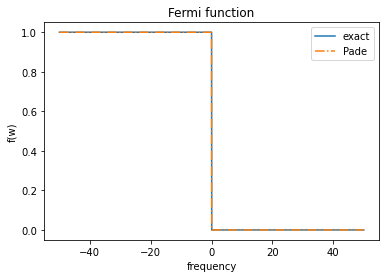

In [5]:
#the Pade scheme
num_pade = 500
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90

pole, tilde_eta = psd(num_pade)

if sigma == -1:
    pole = np.conj(pole)

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / (omega[i] / T + pole[j]) \
                                      + tilde_eta[j] / (omega[i] / T - pole[j])
    if i % 1000 == 0 :
        print("run times / total times:", i ,"/", omega_sample-1, " = ", '%.2f'%(i/(omega_sample-1)))


plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega_plt, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega_plt, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
#plt.xlim(chemical_potential-50,chemical_potential+50)
plt.show()

In [6]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.

eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - sigma * 1.j  * band_center) / hbar
spectral_eta_pade = (0.5 * sys_bath_coupling) * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate ) * hbar) / hbar**2

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = (-1.j * sigma * T * pole[i - 1] ) / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

    
print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade)
print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

pade_diss_rate 
 [-5.00000000e+00+0.j -3.14159265e-03+0.j -9.42477796e-03+0.j
 -1.57079633e-02+0.j -2.19911486e-02+0.j -2.82743339e-02+0.j
 -3.45575192e-02+0.j -4.08407045e-02+0.j -4.71238898e-02+0.j
 -5.34070751e-02+0.j -5.96902604e-02+0.j -6.59734457e-02+0.j
 -7.22566310e-02+0.j -7.85398163e-02+0.j -8.48230016e-02+0.j
 -9.11061870e-02+0.j -9.73893723e-02+0.j -1.03672558e-01+0.j
 -1.09955743e-01+0.j -1.16238928e-01+0.j -1.22522113e-01+0.j
 -1.28805299e-01+0.j -1.35088484e-01+0.j -1.41371669e-01+0.j
 -1.47654855e-01+0.j -1.53938040e-01+0.j -1.60221225e-01+0.j
 -1.66504411e-01+0.j -1.72787596e-01+0.j -1.79070781e-01+0.j
 -1.85353967e-01+0.j -1.91637152e-01+0.j -1.97920337e-01+0.j
 -2.04203522e-01+0.j -2.10486708e-01+0.j -2.16769893e-01+0.j
 -2.23053078e-01+0.j -2.29336264e-01+0.j -2.35619449e-01+0.j
 -2.41902634e-01+0.j -2.48185820e-01+0.j -2.54469005e-01+0.j
 -2.60752190e-01+0.j -2.67035376e-01+0.j -2.73318561e-01+0.j
 -2.79601746e-01+0.j -2.85884931e-01+0.j -2.92168117e-01+0.j
 -2.984

In [7]:
# pade results
if sigma == 1:
    for i in range(time_sample_for_corr):
        for j in range(num_pade + 1):
            bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * np.exp(-1 * diss_rate_pade[j] * tt_for_corr[i])
            

elif sigma == -1 :       
    for i in range(time_sample_for_corr):
        for j in range(num_pade + 1):
            bath_corr_psd[i] = bath_corr_psd[i] + np.conj(eta_pade[j]) * np.exp(-1 * np.conj(diss_rate_pade[j]) * tt_for_corr[i])

print('Done!')

Done!


In [8]:
# prony results
dimension_Hankel = int (3000 * 1)
num_prony = 6
tt_for_prony_min = 0.0
tt_for_prony_max = 184.0
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi_real = np.zeros(time_sample_for_prony)
phi_imag = np.zeros(time_sample_for_prony)

print(tt_for_prony[1])

i = 0
if sigma == 1 :
    for j in range(time_sample_for_prony):
        i = i + 1
        for k in  range(num_pade + 1):
            phi_real[j] = phi_real[j] + np.real(eta_pade[k] * np.exp(-1 * diss_rate_pade[k] * tt_for_prony[j])) 
            phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * np.exp(-1 * diss_rate_pade[k] * tt_for_prony[j]))
        if i % 500 == 0 :
            print("run times / total times:", i ,"/", time_sample_for_prony-1, " = ", '%.2f'%(i/(time_sample_for_prony-1)))

elif sigma == -1 :
    for j in range(time_sample_for_prony):
        i = i + 1
        for k in  range(num_pade + 1):
            phi_real[j] = phi_real[j] + np.real(np.conj(eta_pade[k]) * np.exp(-1 * np.conj(diss_rate_pade[k]) * tt_for_prony[j])) 
            phi_imag[j] = phi_imag[j] + np.imag(np.conj(eta_pade[k]) * np.exp(-1 * np.conj(diss_rate_pade[k]) * tt_for_prony[j]))
        if i % 500 == 0 :
            print("run times / total times:", i ,"/", time_sample_for_prony-1, " = ", '%.2f'%(i/(time_sample_for_prony-1)))
        
for n in range(dimension_Hankel + 1):
    for m in range(dimension_Hankel + 1):
        hankel_matrix_real[n,m] = phi_real[n + m]
        hankel_matrix_imag[n,m] = phi_imag[n + m]
        
print('Done!')

0.03103448275862069
run times / total times: 500 / 5800  =  0.09
run times / total times: 1000 / 5800  =  0.17
run times / total times: 1500 / 5800  =  0.26
run times / total times: 2000 / 5800  =  0.34
run times / total times: 2500 / 5800  =  0.43
run times / total times: 3000 / 5800  =  0.52
run times / total times: 3500 / 5800  =  0.60
run times / total times: 4000 / 5800  =  0.69
run times / total times: 4500 / 5800  =  0.78
run times / total times: 5000 / 5800  =  0.86
run times / total times: 5500 / 5800  =  0.95
Done!


In [9]:
sigma_real, U_real = takagi_chen(hankel_matrix_real)
sigma_imag, U_imag = takagi_chen(hankel_matrix_imag)

print(
    "error of decompose real part\n",
    np.sum(np.abs(hankel_matrix_real - np.dot(np.dot(U_real, np.diag(sigma_real)), U_real.T))), "\n"
    "error of decompose imag part\n",
    np.sum(np.abs(hankel_matrix_imag - np.dot(np.dot(U_imag, np.diag(sigma_imag)), U_imag.T))))

print('Done!')

error of decompose real part
 2.3960674717687904e-14 
error of decompose imag part
 4.195075437460494e-11
Done!


In [10]:
prony_roots_real = np.roots(U_real[:, num_prony][::-1])
tmp_index_real = prony_roots_real != 0
prony_roots_real = prony_roots_real[tmp_index_real]
prony_roots_real_new = prony_roots_real[np.argsort(np.abs(prony_roots_real))[:num_prony]]

print('Done!')

Done!


In [11]:
prony_roots_imag = np.roots(U_imag[:, num_prony][::-1])
tmp_index_imag = prony_roots_imag != 0
prony_roots_imag = prony_roots_imag[tmp_index_imag]
prony_roots_imag_new = prony_roots_imag[np.argsort(np.abs(prony_roots_imag))[:num_prony]]
a = np.argsort(np.abs(prony_roots_imag))[:num_prony]

print('Done!')

Done!


In [12]:
omega_matrix_real = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_real[i, j] = prony_roots_real_new[j]**i
eta_prony_real_tmp = np.dot(linalg.inv(np.dot(omega_matrix_real.T, omega_matrix_real)), np.dot(omega_matrix_real.T, phi_real))

omega_matrix_imag = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_imag[i, j] = prony_roots_imag_new[j]**i
eta_prony_imag_tmp = np.dot(linalg.inv(np.dot(omega_matrix_imag.T, omega_matrix_imag)), np.dot(omega_matrix_imag.T, phi_imag))

print('Done!')

Done!


In [13]:
bath_corr_prony = np.zeros(time_sample_for_corr, dtype=complex)

diss_rate_prony_real_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_real_new ) ) + 1.j * np.angle(prony_roots_real_new) )
diss_rate_prony_imag_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_imag_new ) ) + 1.j * np.angle(prony_roots_imag_new) )

eta_prony = np.zeros(2 * num_prony , dtype = complex)
diss_rate_prony = np.zeros(2 * num_prony, dtype = complex)

eta_prony[0:num_prony] = eta_prony_imag_tmp * 1.j
eta_prony[num_prony:2 * num_prony] = eta_prony_real_tmp

diss_rate_prony[0:num_prony] = diss_rate_prony_imag_tmp
diss_rate_prony[num_prony:2*num_prony] = diss_rate_prony_real_tmp

for i in range(time_sample_for_corr):
    for j in range(2 * num_prony):
        bath_corr_prony[i] = bath_corr_prony[i] + eta_prony[j] * np.exp(-1 * diss_rate_prony[j] * tt_for_corr[i])

print("diss_rate_prony\n",diss_rate_prony)
print("eta_prony\n",eta_prony)

print('Done!')

diss_rate_prony
 [2.11987154e+01-0.00000000e+00j 3.25756256e+00-1.26570375e-16j
 6.85438809e-01+2.48754517e-14j 1.48765601e-01+2.80776546e-15j
 3.02962884e-02+2.49641735e-13j 4.25687165e-03-2.09520788e-13j
 8.61608157e+00-1.87016959e+01j 8.61608157e+00+1.87016959e+01j
 7.59633757e+00-3.10474451e-15j 7.47302818e+00+7.35343173e+01j
 7.47302818e+00-7.35343173e+01j 6.87298085e+00+1.01229097e+02j]
eta_prony
 [ 8.17621970e-14+1.86598440e+00j -1.64522726e-13-1.56176638e+00j
  2.02659185e-13-2.55263658e-01j -2.30563065e-13-5.53153886e-02j
  1.77650499e-13-1.24561190e-02j -5.06913642e-14-2.58053325e-03j
  1.85962357e-14-9.27036226e-15j  1.88460358e-14+1.18793864e-14j
  2.88521723e+00-9.39130836e-16j  3.66373598e-15+2.88657986e-15j
  4.27435864e-15-3.10862447e-15j  3.99680289e-15+4.40899546e-16j]
Done!


In [123]:
#the Pade scheme
num_pade_small = num_prony * 2
tilde_eta_small = np.zeros(num_pade_small, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole_small = np.zeros(num_pade_small, dtype = complex)              # namely cppole in evaluatepara.f90
bath_corr_psd_small = np.zeros(time_sample_for_corr, dtype = complex)

pole_small, tilde_eta_small = psd(num_pade_small)

if sigma == -1:
    pole_small = np.conj(pole_small)

# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade_small = np.zeros(num_pade_small + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade_small = np.zeros(num_pade_small + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

diss_rate_pade_small[0] = spectral_diss_rate_pade
eta_pade_small[0] = spectral_eta_pade

for i in range(1, num_pade_small + 1):
    diss_rate_pade_small[i] = (-1.j * sigma * T * pole_small[i - 1]) / hbar
    eta_pade_small[i] = 2.j * tilde_eta_small[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole_small[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

print('pade_diss_rate_small \n', -1 * diss_rate_pade_small * hbar)
print('pade_eta_small \n', eta_pade_small)
print('pade_eta_small * hbar**2 \n', eta_pade_small * hbar**2)

# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade_small + 1):
        bath_corr_psd_small[i] = bath_corr_psd_small[i] + eta_pade_small[j] * np.exp(-1 * diss_rate_pade_small[j] * tt_for_corr[i])

print('Done!')

pade_diss_rate_small 
 [-5.00000000e+00+0.j -3.14159265e-03+0.j -9.42477796e-03+0.j
 -1.57079633e-02+0.j -2.19911486e-02+0.j -2.82743340e-02+0.j
 -3.45576918e-02+0.j -4.08715540e-02+0.j -4.78922148e-02+0.j
 -5.86075095e-02+0.j -7.91286297e-02+0.j -1.28908374e-01+0.j
 -3.82491286e-01+0.j]
pade_eta_small 
 [2.88521723-7.27198167e+00j 0.        -2.30817469e-03j
 0.        -2.30818198e-03j 0.        -2.30819656e-03j
 0.        -2.30821843e-03j 0.        -2.30824789e-03j
 0.        -2.30868306e-03j 0.        -2.35508586e-03j
 0.        -2.99355457e-03j 0.        -5.21359729e-03j
 0.        -1.07816875e-02j 0.        -3.07999316e-02j
 0.        -2.81906804e-01j]
pade_eta_small * hbar**2 
 [1.25-3.15053473e+00j 0.  -1.00000039e-03j 0.  -1.00000355e-03j
 0.  -1.00000987e-03j 0.  -1.00001934e-03j 0.  -1.00003211e-03j
 0.  -1.00022064e-03j 0.  -1.02032433e-03j 0.  -1.29693639e-03j
 0.  -2.25875423e-03j 0.  -4.67109001e-03j 0.  -1.33438530e-02j
 0.  -1.22134133e-01j]
Done!


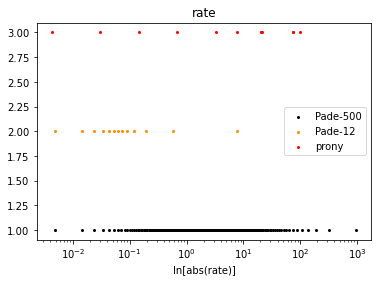

In [15]:
one = np.ones(len(diss_rate_pade))
two =  np.ones(len(diss_rate_pade_small)) * 2
three =  np.ones(len(diss_rate_prony)) * 3

plt.title("rate") 
plt.xlabel("ln[abs(rate)]") 
plt.ylabel("") 
plt.scatter(np.abs(diss_rate_pade), one, label = 'Pade-%d' %num_pade, s = 4, color = 'k') 
plt.scatter(np.abs(diss_rate_pade_small), two, label = 'Pade-%d' %num_pade_small, s = 4, color = 'darkorange') 
plt.scatter(np.abs(diss_rate_prony), three, label = 'prony', s = 4, color = 'r') 
plt.legend(loc=7)
plt.xscale("log")
#plt.xlim(-0.1, 1.5)
plt.show()

In [198]:
path = "../fortran/diy-Takagi/"
eta_real_fortran = np.loadtxt((path + "eta_real.data"))
eta_imag_fortran = np.loadtxt((path + "eta_imag.data"))
diss_rate_real_fortran = np.loadtxt((path + "rate_real.data"))
diss_rate_imag_fortran = np.loadtxt((path + "rate_imag.data"))

eta_fortran = (eta_real_fortran + 1.j * eta_imag_fortran)
diss_rate_fortran = (diss_rate_real_fortran + 1.j * diss_rate_imag_fortran)

print("diss_rate_prony_fortran\n",diss_rate_fortran)
print("eta_prony_fortran\n",eta_fortran)

bath_corr_prony_fortran = np.zeros(time_sample_for_corr, dtype = complex)

for i in range(time_sample_for_corr):
    for j in range(len(eta_fortran)):
        bath_corr_prony_fortran[i] = bath_corr_prony_fortran[i] + eta_fortran[j] * np.exp(-1 * diss_rate_fortran[j] * tt_for_corr[i])


diss_rate_prony_fortran
 [9.86997440e+01+0.00000000e+00j 2.86040985e+01+0.00000000e+00j
 1.15190872e+01+0.00000000e+00j 5.08266212e+00-1.81188050e-15j
 2.33430481e+00+4.68878508e-14j 1.08976293e+00-1.12989749e-13j
 5.11421838e-01+8.76665177e-13j 2.39622561e-01-3.61764551e-12j
 1.10637477e-01+7.76471086e-12j 4.84393956e-02-9.60917441e-12j
 1.86351961e-02+7.30120415e-12j 4.86813086e-03-2.57280802e-12j
 1.00942545e+01-3.28192939e+01j 1.00942545e+01+3.28192939e+01j
 7.59633757e+00-1.77726276e-13j 7.30941313e+00-8.95226882e+01j]
eta_prony_fortran
 [ 9.73767965e-13+2.78476884e-01j -3.35150549e-12+5.19257323e-01j
  6.38179057e-12+1.82497251e+00j -9.46530542e-12-1.76381958e+00j
  1.19931700e-11-4.78271499e-01j -1.37933963e-11-2.03905169e-01j
  1.49219017e-11-9.39310363e-02j -1.48062206e-11-4.41912520e-02j
  1.23075468e-11-2.11322017e-02j -7.66995116e-12-1.02526674e-02j
  3.19207034e-12-4.74389157e-03j -6.81093421e-13-2.45954483e-03j
  2.76445533e-14+1.32671651e-14j -2.55351296e-15+1.54876112e-

In [199]:
path = "../fano/"

# read cb(nvar2,nspin,ncor,nalf,nsgn)
cb_real = np.loadtxt((path + "res_corr.data"), skiprows=5, usecols=6, dtype = np.float64)
cb_img = np.loadtxt((path + "res_corr.data"), skiprows=5, usecols=7, dtype = np.float64)
eta_fano = np.zeros((cb_real.shape), dtype=complex)
for i in range(cb_real.size):
    eta_fano[i] = complex(cb_real[i], cb_img[i])


# read cgama(nvar2,nspin,ncor,nalf,nsgn)
cgama_real = np.loadtxt((path + "res_corr.data"), skiprows=5, usecols=10, dtype = np.float64)
cgama_img = np.loadtxt((path + "res_corr.data"), skiprows=5, usecols=11, dtype = np.float64)
diss_rate_fano = np.zeros((cb_real.shape), dtype=complex)
for i in range(cb_real.size):
    diss_rate_fano[i] = -complex(cgama_real[i], cgama_img[i])


# read ifff(nvar2,nspin,ncor,nalf,nsgn)
mp = np.loadtxt((path + "res_corr.data"), skiprows=5, usecols=12, dtype = int)


print("diss_rate_prony_fano\n",-diss_rate_fano * hbar)
print("mp\n", mp)
print("eta_prony_fano\n",eta_fano)

bath_corr_fano = np.zeros(time_sample_for_corr, dtype = complex)

for i in range(time_sample_for_corr):
    for j in range(len(eta_fano)):
        bath_corr_fano[i] = bath_corr_fano[i] + (eta_fano[j]) * (tt_for_corr[i])**mp[j]\
                                  * np.exp(-1 * diss_rate_fano[j] * tt_for_corr[i])


diss_rate_prony_fano
 [-5.00000000e+00+0.j -3.14246679e+00+0.j -1.30431937e+01+0.j
 -3.70919881e-03+0.j -3.55320570e-02+0.j -3.55320570e-02+0.j
 -3.83030229e-01+0.j -3.83030229e-01+0.j -1.32495959e+00+0.j
 -1.32495959e+00+0.j -1.56825845e-01+0.j -1.56825845e-01+0.j
 -1.56825845e-01+0.j]
mp
 [0 0 0 0 0 1 0 1 0 1 0 1 2]
eta_prony_fano
 [2.88521723+2.14059305e+00j 0.        -3.82410881e+00j
 0.        +1.58954422e+00j 0.        -3.33587801e-03j
 0.        +1.33236240e-06j 0.        -7.12072723e-04j
 0.        +2.14130351e-03j 0.        -1.05543936e-01j
 0.        +9.51649251e-02j 0.        -1.26823113e+00j
 0.        -1.40674072e-07j 0.        -4.30344708e-03j
 0.        -1.02939583e-03j]


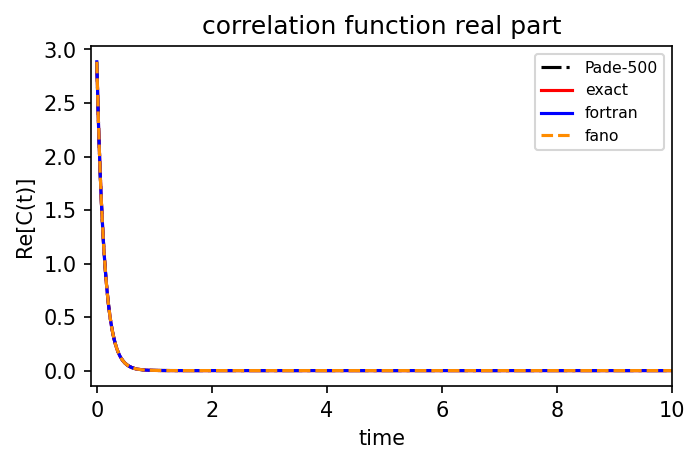

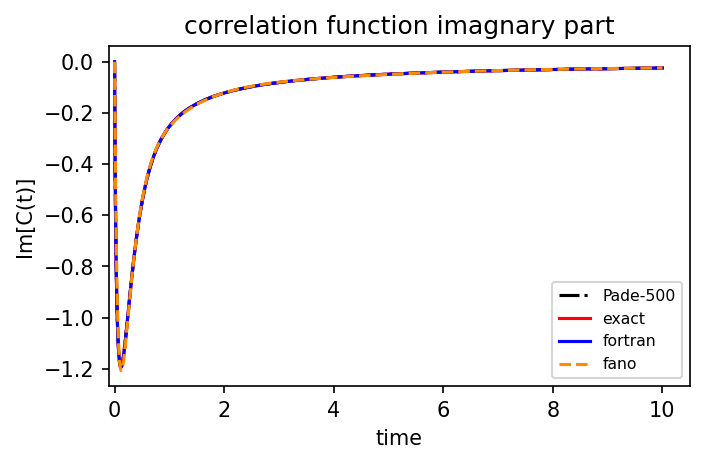

In [200]:
plt.figure(figsize=(5,3), dpi = 150)

plt.title("correlation function real part") 
plt.xlabel("time") 
plt.ylabel("Re[C(t)]") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
#plt.scatter(tt_for_corr, bath_corr_psd_small.real, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_real / (np.pi * hbar **2), label = 'exact', color = 'r') 
#plt.plot(tt_for_corr, bath_corr_prony.real, label = 'prony', linestyle = '--', color = 'g')
plt.plot(tt_for_corr, bath_corr_prony_fortran.real, label = 'fortran', color = 'b')
plt.plot(tt_for_corr, bath_corr_fano.real, label = 'fano', linestyle = '--', color = 'darkorange')
plt.legend(loc=1, fontsize = 7.5)
plt.xlim(-0.1, 10)
plt.show()


plt.figure(figsize=(5,3), dpi = 150)

plt.title("correlation function imagnary part") 
plt.xlabel("time") 
plt.ylabel("Im[C(t)]") 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
#plt.scatter(tt_for_corr, bath_corr_psd_small.imag, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_imag / (np.pi * hbar **2), label = 'exact', color = 'r') 
#plt.plot(tt_for_corr, bath_corr_prony.imag, label = 'prony', linestyle = '--', color = 'g')
plt.plot(tt_for_corr, bath_corr_prony_fortran.imag, label = 'fortran', color = 'b')
plt.plot(tt_for_corr, bath_corr_fano.imag, label = 'fano', linestyle = '--', color = 'darkorange')
plt.legend(loc=4, fontsize = 7.5)
plt.xlim(-0.110)
plt.show()

In [201]:
sigma = 1

omega_sample_ = (omega_sample - 1) * 10
omega_max_ = 10
omega_min_ = -10

omega_plt = np.linspace(omega_min_, omega_max_, omega_sample_)

bath_corr_psd_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_psd_small_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_prony_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_fortran_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_exact_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_fano_freq = np.zeros(omega_sample_, dtype = complex)

print("Done!")

Done!


In [202]:
fermi_ = np.zeros(omega_sample_)
bath_spectral_ = np.zeros(omega_sample_)
for i in range(omega_sample_):
    if (sigma * omega_plt[i] / (T)) <= 50 :
        fermi_[i] = 1.0 / ( 1.0 + np.exp( sigma * omega_plt[i] * hbar / (T) ) )
    elif (sigma * omega_plt[i] / (T)) > 50 :
        fermi_[i] = 1.0 / 10e+22
bath_spectral_ = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega_plt * hbar - sigma * band_center)**2 + band_width**2)

bath_corr_exact_freq = bath_spectral_ * fermi_ / hbar


print("Done!")

Done!


In [203]:
if sigma == 1 :
    for i in range(omega_sample_):
        #bath_corr_psd_small_freq[i] = J_fit(omega_plt[i], diss_rate_pade_small * hbar, eta_pade_small * hbar**2)
        bath_corr_psd_freq[i] = J_fit(omega_plt[i], diss_rate_pade, eta_pade)
    #   bath_corr_prony_freq[i] = J_fit(omega_plt[i], diss_rate_prony, eta_prony)
        bath_corr_fortran_freq[i] = J_fit(omega_plt[i], diss_rate_fortran, eta_fortran)
        bath_corr_fano_freq[i] = J_fit_fano(omega_plt[i], diss_rate_fano, eta_fano, mp)

elif sigma == -1 :
    for i in range(omega_sample_):
        #bath_corr_psd_small_freq[i] = J_fit(omega_plt[i], diss_rate_pade_small * hbar, eta_pade_small * hbar**2)
        bath_corr_psd_freq[i] = J_fit(omega_plt[i], np.conj(diss_rate_pade), np.conj(eta_pade))
    #     bath_corr_prony_freq[i] = J_fit(omega_plt[i], diss_rate_prony, eta_prony)
        bath_corr_fortran_freq[i] = J_fit(omega_plt[i], np.conj(diss_rate_fortran), np.conj(eta_fortran))
        bath_corr_fano_freq[i] = J_fit_fano(omega_plt[i], np.conj(diss_rate_fano), np.conj(eta_fano), mp)

print("Done!")

Done!


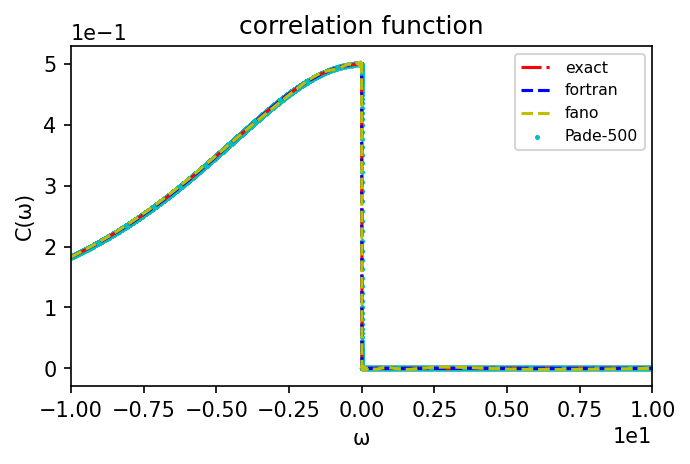

 0.0009000090000910177 
 psd   0.27049428793488983 
 exact 0.270494287934947 
 prony 0.0
 small 0.0

 0.001100011000110257 
 psd   0.24802337087205276 
 exact 0.24802337087212253 
 prony 0.0
 small 0.0

 0.0013000130001312726 
 psd   0.2265545754430152 
 exact 0.22655457544309618 
 prony 0.0
 small 0.0


In [204]:
plt.figure(figsize=(5,3), dpi = 150)

plt.title("correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
#plt.scatter(omega_plt, bath_corr_psd_small_freq.real, label = 'Pade-%d'%num_pade_small, s = 5, color = 'darkorange')
plt.scatter(omega_plt, bath_corr_psd_freq.real * hbar, label = 'Pade-%d'%num_pade, s = 2, color = 'c')
plt.plot(omega_plt, bath_corr_exact_freq.real * hbar, label = 'exact', linestyle = '-.', color = 'r')
# plt.scatter(omega_plt, bath_corr_prony_freq.real * hbar, label = 'python', s = 2, color = 'lime')
plt.plot(omega_plt, bath_corr_fortran_freq.real * hbar, label = 'fortran', linestyle = '--', color = 'b')
plt.plot(omega_plt, bath_corr_fano_freq.real * hbar, label = 'fano', linestyle = '--', color = 'y')
plt.legend(loc=1, fontsize = 7.5)
plt.xlim(-10, 10)
#plt.ylim(-0.001, 0.005)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

x = 50005
a = max(np.abs(bath_corr_psd_freq.real))
b = max(np.abs(bath_corr_exact_freq.real))
c = max(np.abs(bath_corr_prony_freq.real))
print('',omega_plt[x-1],'\n psd  ',(bath_corr_psd_freq[x-1]).real,'\n exact',bath_corr_exact_freq[x-1],\
      '\n prony',(bath_corr_prony_freq[x-1]).real)
print(' small', bath_corr_psd_small_freq[x-1].real)
print()
print('',omega_plt[x],'\n psd  ',(bath_corr_psd_freq[x]).real,'\n exact',bath_corr_exact_freq[x],\
      '\n prony',(bath_corr_prony_freq[x]).real)
print(' small', bath_corr_psd_small_freq[x].real)
print()
print('',omega_plt[x+1],'\n psd  ',(bath_corr_psd_freq[x+1]).real,'\n exact',bath_corr_exact_freq[x+1],\
      '\n prony',(bath_corr_prony_freq[x+1]).real)
print(' small', bath_corr_psd_small_freq[x+1].real)

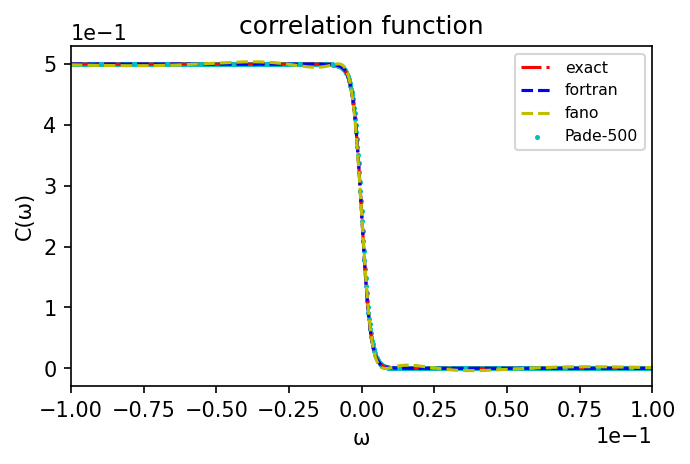

In [205]:
plt.figure(figsize=(5,3), dpi = 150)

plt.title("correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
#plt.scatter(omega_plt, bath_corr_psd_small_freq.real, label = 'Pade-%d'%num_pade_small, s = 5, color = 'darkorange')
plt.scatter(omega_plt, bath_corr_psd_freq.real * hbar, label = 'Pade-%d'%num_pade, s = 2, color = 'c')
plt.plot(omega_plt, bath_corr_exact_freq.real * hbar, label = 'exact', linestyle = '-.', color = 'r')
# plt.scatter(omega_plt, bath_corr_prony_freq.real * hbar, label = 'python', s = 2, color = 'lime')
plt.plot(omega_plt, bath_corr_fortran_freq.real * hbar, label = 'fortran', linestyle = '--', color = 'b')
plt.plot(omega_plt, bath_corr_fano_freq.real * hbar, label = 'fano', linestyle = '--', color = 'y')
plt.legend(loc=1, fontsize = 7.5)
plt.xlim(-0.1, 0.1)
#plt.ylim(-0.001, 0.005)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

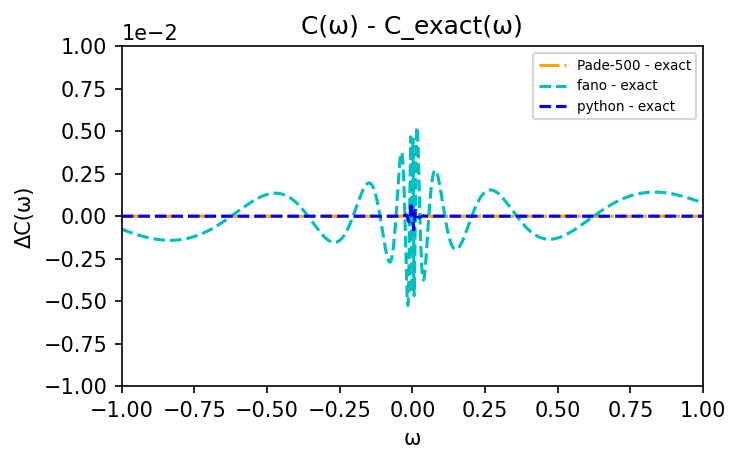

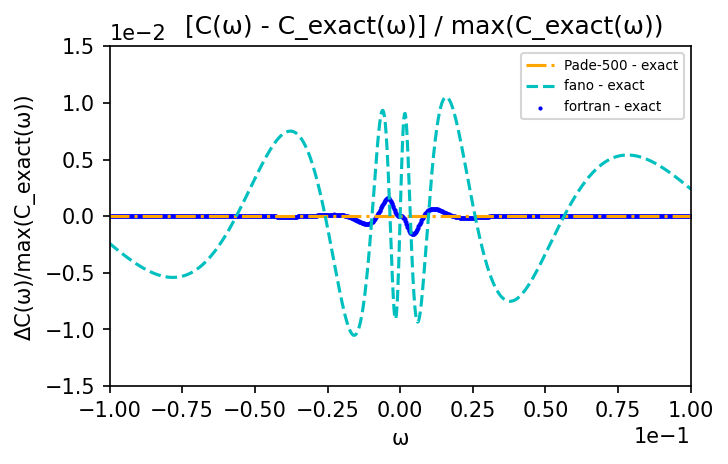

In [211]:
plt.figure(figsize=(5,3), dpi = 150)

plt.title("C(ω) - C_exact(ω)") 
plt.xlabel("ω") 
plt.ylabel("ΔC(ω)")
#plt.scatter(omega_plt, (bath_corr_fortran_freq.real - bath_corr_exact_freq.real) * hbar, label = 'fortran - exact', s = 1, color = 'b')
plt.plot(omega_plt, (bath_corr_psd_freq.real - bath_corr_exact_freq.real) * hbar, label = 'Pade-%d - exact'%num_pade, linestyle = '-.', color = 'orange')
plt.plot(omega_plt, (bath_corr_fano_freq.real - bath_corr_exact_freq.real) * hbar, label = 'fano - exact', linestyle = '--', color = 'c')
plt.plot(omega_plt, (bath_corr_fortran_freq.real - bath_corr_exact_freq.real) * hbar, label = 'python - exact', linestyle = '--', color = 'b')

plt.legend(loc=1, fontsize = 6.5)
plt.xlim(-1.0, 1.0)
plt.ylim(-0.01, 0.01)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()


plt.figure(figsize=(5,3), dpi = 150)

plt.title("      [C(ω) - C_exact(ω)] / max(C_exact(ω))") 
plt.xlabel("ω") 
plt.ylabel("ΔC(ω)/max(C_exact(ω))")
plt.scatter(omega_plt, (bath_corr_fortran_freq.real - bath_corr_exact_freq.real)/ max(bath_corr_exact_freq.real), label = 'fortran - exact', s = 1, color = 'b')
plt.plot(omega_plt, (bath_corr_psd_freq.real - bath_corr_exact_freq.real)/ max(bath_corr_exact_freq.real), label = 'Pade-%d - exact'%num_pade, linestyle = '-.', color = 'orange')
#plt.plot(omega_plt, (bath_corr_prony_freq.real - bath_corr_exact_freq.real)/ max(bath_corr_exact_freq.real), label = 'python - exact', linestyle = '--', color = 'r')
plt.plot(omega_plt, (bath_corr_fano_freq.real - bath_corr_exact_freq.real)/ max(bath_corr_exact_freq.real), label = 'fano - exact', linestyle = '--', color = 'c')

plt.legend(loc=1, fontsize = 6.5)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.015, 0.015)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()


In [207]:
err_fano = np.sum(np.abs(bath_corr_fano_freq.real - bath_corr_exact_freq.real)) / omega_sample_
err_fortran = np.sum(np.abs(bath_corr_fortran_freq.real - bath_corr_exact_freq.real)) / omega_sample_

print("err_fano", err_fano)
print("err_fortran", err_fortran)

err_fano 0.0017704555632886345
err_fortran 1.3469391328268053e-05


In [ ]:
# save ω and output C(ω)

# dimension_Hankel_ = 3200
# tt_for_prony_max_ = 184
# path_save = "./save/"

# np.savetxt((path_save + "exact" + "-%d"%dimension_Hankel_ + "-tmax=" + "%d"%tt_for_prony_max_ + ".data"), (bath_corr_exact_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "psd" + "-%d"%dimension_Hankel_ + "-tmax=" + "%d"%tt_for_prony_max_ + ".data"), (bath_corr_psd_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "fortran" + "-%d"%dimension_Hankel_ + "-tmax=" + "%d"%tt_for_prony_max_ + ".data"), (bath_corr_fortran_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "fano" + "-%d"%dimension_Hankel_ + "-tmax=" + "%d"%tt_for_prony_max_ + ".data"), (bath_corr_fano_freq.real * hbar), delimiter='\n')

In [ ]:
# np.savetxt((path_save + "exact" + "-%.4f"%tt_for_prony[1] + ".data"), (bath_corr_exact_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "psd" + "-%.4f"%tt_for_prony[1] + ".data"), (bath_corr_psd_freq.real * hbar), delimiter='\n')
# #np.savetxt((path_save + "python" + "-%.4f"%tt_for_prony[1] + ".data"), (bath_corr_prony_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "fortran" + "-%.4f"%tt_for_prony[1] + ".data"), (bath_corr_fortran_freq.real * hbar), delimiter='\n')
# np.savetxt((path_save + "fano" + "-%.4f"%tt_for_prony[1] + ".data"), (bath_corr_fano_freq.real * hbar), delimiter='\n')